# Mamba in pytorch
In this project I've built the mamba architecture in pytorch without the cuda kernels optimization but with the scan and all of that. It's very slow and unresourceful, but performance/weight still seems equal to the original. I'm planning to reimplement the cuda kernels also but that will be a much longer project. But although it did not match the performance it was quite an educative journey:).

# Setup

imports

In [1]:
import torch
import random
from torch import nn, optim, stack, tensor, flatten
from torch.nn import functional as F
import numpy as np
from einops import rearrange
from torch.utils.data import Dataset, DataLoader, random_split
import requests
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Selective_Scan



**Note**: the parallel scan I've implemented here is suited for context length that is 2**d - 1 for integer d.

(The reason is that you need the last place for kinda padding)
The reference for the scan I implemented:

upsweep:

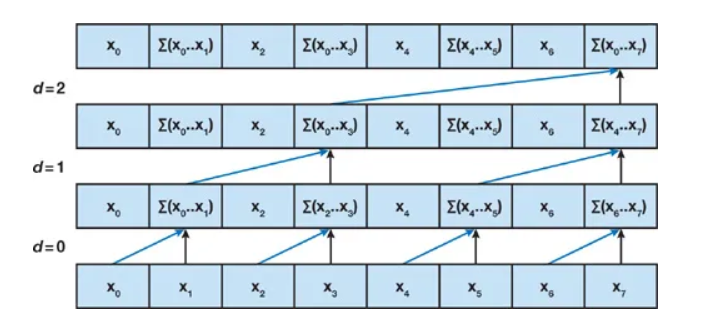

downsweep :

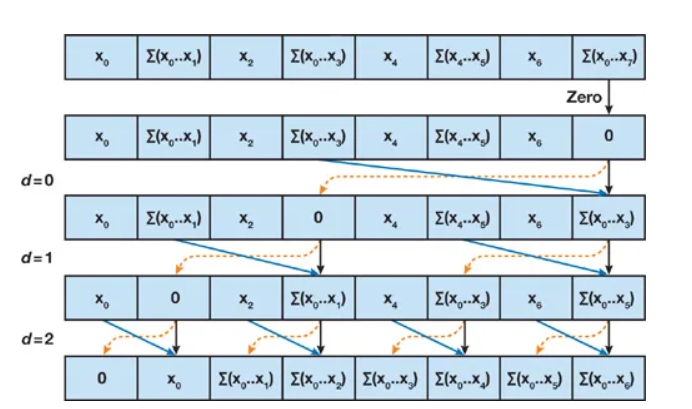

**Note:** that the end result has sum(x0...x6) without x7

I've implemented two versions of the scan, this version is a version that could not track the gradient with auto-grad but is simpler.

In [2]:
# @torch.compile
# def selective_scan(discretized_A, discretized_B, C):
#     B, L, D, N = discretized_B.shape
#     assert (2 ** np.log2(L + 1) == L + 1), "The scan I implemented is built for context length 2**d - 1 for integer d"

#     # padding with zero at the last index for the L dim
#     padding_tensor = torch.zeros(B, 1, D, N, device=discretized_B.device)
#     discretized_A = torch.cat([discretized_A, padding_tensor], dim = 1)
#     discretized_B = torch.cat([discretized_B, padding_tensor], dim = 1)
#     L = L + 1

#     # Up-sweep phase
#     for d in range(int(np.log2(L))):
#         step = 2 ** (d + 1)
#         discretized_B[:, step - 1::step] += discretized_A[:, step - 1::step] * discretized_B[:, step // 2 - 1::step]
#         discretized_A[:, step - 1::step] *= discretized_A[:, step // 2 - 1::step]

#     # Set last element to 0 for exclusive scan
#     discretized_B[:, -1] = 0

#     # Down-sweep phase
#     for d in range(int(np.log2(L)) - 1, -1, -1):
#         step = 2 ** (d + 1)
#         temp = discretized_B[:, step // 2 - 1::step].clone()
#         discretized_B[:, step // 2 - 1::step] = discretized_B[:, step - 1::step]
#         discretized_B[:, step - 1::step] = temp + discretized_B[:, step - 1::step] * discretized_A[:, step // 2 - 1::step]

#     # now let's cut out the padding(that's now propagated into the 1st index)
#     discretized_B = discretized_B[:, 1:]
#     discretized_A = discretized_A[:, 1:]

#     return torch.einsum("bldn,bln->bld", discretized_B, C)

The next version is a version that does not use any inplace operations and as a result can track the gradient (the challenging part was to evade sliced assignment (arr[x:y:z] = ...) because it's inplace by definition)

In [3]:
def interleave_time_dim(a,b):
    return rearrange([a, b], 't h w ...-> h (w t) ...')

In [4]:
def selective_scan(discretized_A, discretized_B, C):
    B, L, D, N = discretized_B.shape
    assert (2 ** np.log2(L + 1) == L + 1), "The scan I implemented is built for context length 2**d - 1 for integer d"

    # padding with zero at the last index for the L dim
    padding_tensor = torch.zeros(B, 1, D, N, device=discretized_B.device)
    discretized_A = torch.cat([discretized_A, padding_tensor], dim = 1)
    discretized_B = torch.cat([discretized_B, padding_tensor], dim = 1)
    L = L + 1

    # in order to have gradient-flow that's valid by torch's autograd we will need to preserve all the vectors on the way
    stacked_states = [(discretized_A.clone(), discretized_B.clone())]
    last_d_A, last_d_B = stacked_states[-1]

    # Up-sweep phase
    for d in range(int(np.log2(L))):
        new_d_A = last_d_A[:, 1::2] * last_d_A[:, ::2]
        new_d_B = last_d_B[:, 1::2] + last_d_A[:, 1::2] * last_d_B[:, ::2]
        stacked_states.append((new_d_A.clone(), new_d_B.clone()))
        last_d_A, last_d_B = stacked_states[-1]

    # Set last element to 0 for exclusive scan
    last_d_A, last_d_B = stacked_states.pop()
    last_d_B[:] = 0

    # Down-sweep phase
    while stacked_states:
        new_d_A, new_d_B = stacked_states.pop()
        last_d_B = interleave_time_dim(last_d_B, new_d_A[:, ::2] * last_d_B + new_d_B[:, ::2])

    # now let's cut out the padding(that's now propagated into the 1st index)
    discretized_B = last_d_B.clone()[:, 1:]
    discretized_A = discretized_A[:, 1:]

    return torch.einsum("bldn,bln->bld", discretized_B, C)

testing

In [5]:
x = tensor([1, 2, 3, 4, 5, 6, 7], dtype=torch.float32)
w = tensor([1, 0.5, 1, 0, 1, 0.5, 1], dtype=torch.float32)
C = torch.ones((1,7,1), dtype=torch.float32)

ground truth function

In [6]:
def calc_weighted_sum(x,w):
    h_t = x[0]
    for idx in range(1, len(x)):
        x[idx] =  w[idx] * h_t + x[idx]
        h_t = x[idx]

    return x

In [7]:
print(calc_weighted_sum(x.clone(),w))

tensor([ 1.0000,  2.5000,  5.5000,  4.0000,  9.0000, 10.5000, 17.5000])


In [8]:
print(selective_scan(w[None,:,None,None],x[None,:,None,None].clone(),C)[0, :, 0])

tensor([ 1.0000,  2.5000,  5.5000,  4.0000,  9.0000, 10.5000, 17.5000])


**Success!**

# S6

In [9]:
# I decided to give up on many hyperparameter of the original implementation
# and make the implementation more clear but with some constants.
class S6(nn.Module):
    def __init__(self, state_dim, ssm_dim, delta_rank, device):
        super().__init__()

        # for the initalization of matrix A we use a nice method:
        # we use the arrange function to initiate all the diagonals to
        # the form of 1..n, and in this way we create a set of timescales(cause A multiply dt)
        # after that we take the log of A to be the parameter so that A = -e ^ log(A) will always be negative
        A = torch.arange(start=1, end = ssm_dim + 1, dtype=torch.float32).repeat(state_dim, 1)
        self.log_A = nn.Parameter(torch.log(A)).to(device)
        # log_A should be somewhere under zero so no weight decay
        self.log_A._no_weight_decay = True

        self.B_proj = nn.Linear(state_dim, ssm_dim, dtype = torch.float32).to(device)

        self.C_proj = nn.Linear(state_dim, ssm_dim, dtype = torch.float32).to(device)

        self.Delta_proj_down = nn.Linear(state_dim, delta_rank, dtype = torch.float32).to(device)

        self.Delta_proj_up = nn.Linear(delta_rank, state_dim, dtype = torch.float32).to(device)

        # first we initiate the weights of delta to fit the variance of the incoming inputs
        # !!! not sure why not just use the already implemented xavier init.
        delta_init_std = delta_rank ** -0.5
        nn.init.uniform_(self.Delta_proj_up.weight, -delta_init_std, delta_init_std)

        # after that we initiate the biases so that softplus(bias) will be in the range (dt_min,dt_max)
        # we do this assuming W*x = 0 (because we don't know what it'll be(and so with stick to the bias we know))
        # to get it we inverse-softplus values sampled from the range (dt_min,dt_max)(the sampling uses log-uniform distribution)
        delta_min, delta_max = 0.001, 0.1
        biases = S6.inverse_softplus(torch.exp((torch.rand(state_dim).to(device) * (delta_max - delta_min)) + delta_min))
        with torch.no_grad():
            self.Delta_proj_up.bias.copy_(biases)
        # this is because we want to init almost all the biases in the end-model to zero (normal practice)
        # so we use a flag to remember that we don't want to reinit the biases we picked here
        self.Delta_proj_up._no_reinit = True

        # D is a skip connection that's weighting skipped values: out = D * in + out
        # we generally want it to be all ones (the eye matrix) so no weight decay
        self.D = nn.Parameter(torch.ones(state_dim, dtype = torch.float32, device = device))
        self.D._no_weight_decay = True

    def forward(self, x):
        B, L, D = x.shape

        deltas = F.softplus(self.Delta_proj_up(self.Delta_proj_down(x)))

        A = -torch.exp(self.log_A)
        dicretized_A = torch.exp(torch.einsum("bld,dn->bldn", deltas, A))

        # here I changed something from the original version:
        # in the original they multiplied discrtized_B with x as the ssm input
        # but I found it strange as discretized_B = deltas * B_matrix * x already
        # though I might be missing something
        discretized_B = torch.einsum("bld,bln->bldn", deltas, self.B_proj(x))

        C = self.C_proj(x)

        out = selective_scan(dicretized_A, discretized_B, C)

        out = out + self.D * x

        return out

    def inverse_softplus(x):
        # expm1 is just e^x - 1 but faster
        return x + torch.log(-torch.expm1(-x))

test

In [ ]:
s6 = S6(65, 4, 2, 'cpu')

x = torch.rand((8,15,65))

print(s6(x))

# Mamba block

In [11]:
class MambaBlock(nn.Module):
    def __init__(self, input_dim, expand, ssm_dim, delta_rank, conv_len, device):
        super().__init__()

        # we want to get from the expand proj both the residual connection and the input for the s6 and conv
        self.expand_proj = nn.Sequential(
            nn.Linear(input_dim, input_dim * expand * 2),
            nn.SiLU(),
            nn.LayerNorm(input_dim * expand * 2)
        ).to(device)

        self.conv = nn.Conv1d(input_dim * expand, input_dim * expand, kernel_size = conv_len, padding='same').to(device)

        self.conv_activation = nn.Sequential(
                    nn.SiLU(),
                    nn.LayerNorm(input_dim * expand)
        ).to(device)

        self.s6 = nn.Sequential(
                    S6(input_dim * expand, ssm_dim, delta_rank, device),
                    nn.SiLU().to(device),
                    nn.LayerNorm(input_dim * expand).to(device)
        )

        self.shrink_proj = nn.Sequential(
            nn.Linear(input_dim * expand, input_dim),
            nn.SiLU(),
            nn.LayerNorm(input_dim)
        ).to(device)

    def forward(self, x):
        expanded = self.expand_proj(x)

        residual_expanded_x, expanded_x = expanded.chunk(2, dim=-1)

        expanded_x = self.conv_activation(self.conv(expanded_x.transpose(1,2)).transpose(1,2))

        expanded_x = self.s6(expanded_x)

        out = self.shrink_proj(expanded_x * residual_expanded_x)

        return out

test

In [ ]:
mamba_block = MambaBlock(240, 1, 4, 2, 2, 'cuda:0')

x = torch.rand((50,127,240)).to('cuda:0')

print(mamba_block(x))

# Mamba complete model

In [13]:
class MambaShakespeare(nn.Module):
    def __init__(self, vocab_size, num_layers, input_dim, expand, ssm_dim, delta_rank, conv_len, device):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, input_dim, device = device)

        self.mamba_blocks = nn.ModuleList([MambaBlock(input_dim, expand, ssm_dim, delta_rank, conv_len, device) for i in range(10)])

        self.output_layer = nn.Sequential(nn.Linear(input_dim, vocab_size),
                                          nn.Softmax(dim = -1)).to(device)

    def forward(self, x):
        x = self.embedding(x)

        for mb in self.mamba_blocks:
            x = mb(x)

        return self.output_layer(x)

test

In [ ]:
vocab_size, num_layers, input_dim, expand, ssm_dim, delta_rank, conv_len, device, seq_len = 6, 3, 65, 1, 5, 2, 2, 'cuda:0', 127

x = torch.randint(0, vocab_size, (1, seq_len)).to(device)

model = MambaShakespeare(vocab_size, num_layers, input_dim, expand, ssm_dim, delta_rank, conv_len, device)

print(model(x))

# Shakespeare dataset

In [15]:
# Download Shakespeare dataset (unchanged)
def download_shakespeare():
    url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    if not os.path.exists("shakespeare.txt"):
        response = requests.get(url)
        with open("shakespeare.txt", "w", encoding="utf-8") as f:
            f.write(response.text)
    with open("shakespeare.txt", "r", encoding="utf-8") as f:
        return f.read()

In [20]:
# Prepare dataset (unchanged)
class ShakespeareDataset(Dataset):
    def __init__(self, text, seq_length):
        # I reduced the dataset to one tenth of the original
        # because the epochs were too long
        self.text = text[:len(text)//10]
        self.seq_length = seq_length
        self.chars = sorted(list(set(self.text)))
        self.char_to_idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(self.chars)}
        self.data = [self.char_to_idx[ch] for ch in self.text]

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        x = torch.tensor(self.data[index:index+self.seq_length], dtype=torch.long)
        y = torch.tensor(self.data[index+1:index+self.seq_length+1], dtype=torch.long)
        return x, y

In [21]:
seq_len = 127
full_dataset = ShakespeareDataset(download_shakespeare(), seq_len)

# config

In [22]:
config = {
    "seq_len" : seq_len,
    "full_dataset" : full_dataset,
    "vocab_size" : len(full_dataset.chars),
    "num_layers" : 3,
    "input_dim" : 128,
    "expand" : 1,
    "ssm_dim" : 32,
    "delta_rank" : 12,
    "conv_len" : 4,
    "device" : torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "lr" : 1e-4,
    "batch_size" : 64,
    "epochs" : 2,
}

# Setup

In [23]:
model = MambaShakespeare(vocab_size=config['vocab_size'],
                         num_layers=config['num_layers'],
                         input_dim=config['input_dim'],
                         expand=config['expand'],
                         ssm_dim=config['ssm_dim'],
                         delta_rank=config['delta_rank'],
                         conv_len=config['conv_len'],
                         device=config['device'])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Split dataset into train and validation
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

# Training loop

In [24]:
torch.cuda.empty_cache()

train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

def calculate_accuracy(output, targets):
    predictions = output.argmax(dim=-1)
    return (predictions == targets).float().mean().item()

for epoch in range(config["epochs"]):
    model.train()
    total_loss, total_accuracy = 0, 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}")

    for batch_idx, (data, targets) in enumerate(progress_bar):
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.view(-1, len(full_dataset.chars)), targets.view(-1))

        if torch.isnan(loss):
            print(f"NaN loss detected at epoch {epoch+1}, batch {batch_idx+1}. Skipping this batch.")
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        accuracy = calculate_accuracy(output.view(-1, len(full_dataset.chars)), targets.view(-1))
        total_accuracy += accuracy
        progress_bar.set_postfix({"Loss": total_loss / (batch_idx + 1), "Accuracy": total_accuracy / (batch_idx + 1)})

    avg_train_loss = total_loss / len(train_loader)
    avg_train_accuracy = total_accuracy / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    # Validation
    model.eval()
    total_val_loss, total_val_accuracy = 0, 0
    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            output = model(data)
            loss = criterion(output.view(-1, len(full_dataset.chars)), targets.view(-1))
            total_val_loss += loss.item()
            accuracy = calculate_accuracy(output.view(-1, len(full_dataset.chars)), targets.view(-1))
            total_val_accuracy += accuracy

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_accuracy = total_val_accuracy / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    print(f"Epoch {epoch+1}/{config['epochs']}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")

    scheduler.step(avg_val_loss)

print("Training completed!")

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, config['epochs']+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, config['epochs']+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot.png')
plt.close()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, config["epochs"]+1), train_losses, label='Train Loss')
plt.plot(range(1, config["epochs"]+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')
plt.close()

print("Accuracy and loss plots have been saved as 'accuracy_plot.png' and 'loss_plot.png'.")

Epoch 1/2: 100%|██████████| 1567/1567 [29:25<00:00,  1.13s/it, Loss=4.08, Accuracy=0.102]


Epoch 1/2, Train Loss: 4.0839, Train Accuracy: 0.1022, Val Loss: 4.0387, Val Accuracy: 0.1446


Epoch 2/2: 100%|██████████| 1567/1567 [29:25<00:00,  1.13s/it, Loss=4.01, Accuracy=0.147]


Epoch 2/2, Train Loss: 4.0119, Train Accuracy: 0.1467, Val Loss: 3.9987, Val Accuracy: 0.1469
Training completed!
Accuracy and loss plots have been saved as 'accuracy_plot.png' and 'loss_plot.png'.
